## Imports and reading the data

In [ ]:
import random
import os,shutil
import numpy as np
import pandas as pd
#For image augmentation we are using imgaug library
!pip install imgaug
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,roc_curve,auc,accuracy_score,roc_auc_score,classification_report

Using TensorFlow backend.


In [ ]:
base_dir=r'/content/drive/My Drive/Hackerearth dance form classification'
train_path=os.path.join(base_dir,'train')
test_path=os.path.join(base_dir,'test')

In [ ]:
data=pd.read_csv(r'/content/drive/My Drive/Hackerearth dance form classification/train.csv')
data.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


In [ ]:
data['target'].value_counts()

mohiniyattam     50
odissi           49
kathakali        47
bharatanatyam    47
kuchipudi        46
sattriya         45
kathak           44
manipuri         36
Name: target, dtype: int64

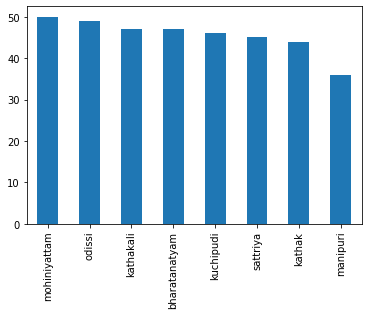

In [ ]:
data['target'].value_counts().plot(kind='bar')

In [ ]:
data.shape[0]

364

## Image preprocessing

In [ ]:
height,width=[],[]
for i in data.index:
    path=os.path.join(train_path,data['Image'][i])
    image = imageio.imread(path)
    image = np.asarray(image)
    height.append(image.shape[0])
    width.append(image.shape[1])

- Creating a list of height and width for all images.

In [ ]:
height=pd.Series(height)
weight=pd.Series(width)
min(height),min(width),height.median(),weight.median()

(126, 139, 275.0, 275.5)

- Finding the minimum and median height and width of the images.
- We will use the median size to resize all the images to the median size.

In [ ]:
def get_img_tensor(image):
    #img = tf.image.decode_jpeg(image, channels=3) 
    image = np.asarray(image)
    image=image/255.0
    #img = tf.image.convert_image_dtype(image, tf.float64)
    img_tensor = tf.image.resize(image, [275, 275])
    img_tensor = np.resize(img_tensor,(1,275,275,3)) # sample height width channels - Format of the tensor
    return img_tensor

- A function which takes as input an image and returns a tensor(numpy array) with the required dimnsions.

In [ ]:
labels={'mohiniyattam':0,'odissi':1,'kathakali':2,'bharatanatyam':3,'kuchipudi':4,'sattriya':5,'kathak':6,'manipuri':7}
train_x=np.empty((data.shape[0]*5,275,275,3),dtype='float32') #5 has been used because we are using 4 augmentations, thus 4(augmented)+1(original)=5
train_y=np.empty((data.shape[0]*5,1),dtype='float32') #float64 can also be used but it requires a lot of memory
count=0
for i in data.index:
    path=os.path.join(train_path,data['Image'][i])
    image = imageio.imread(path)
    #image = tf.io.read_file(path)
  
    # Original image
    train_x[count] = get_img_tensor(image)
    train_y[count] = labels[data['target'][i]]
    count+=1

    # Cropped image
    crop = iaa.Crop(percent=(0, 0.35)) # crop image
    crop_image=crop.augment_image(image) 
    train_x[count] = get_img_tensor(crop_image)
    train_y[count] = labels[data['target'][i]]
    count+=1

    # Shear image
    shear = iaa.Affine(shear=(0,40))
    shear_image=shear.augment_image(image)
    train_x[count] = get_img_tensor(shear_image)
    +=1

    # Rotated image
    rotate=iaa.Affine(rotate=(-50, 30))
    rotated_image=rotate.augment_image(image)
    train_x[count] = get_img_tensor(rotated_image)
    train_y[count] = labels[data['target'][i]]
    count+=1

    # Horizontally flipped image
    flip_hr=iaa.Fliplr(p=1.0)
    flip_hr_image= flip_hr.augment_image(image)
    train_x[count] = get_img_tensor(flip_hr_image)
    train_y[count] = labels[data['target'][i]]
    count+=1

- A function which uses image augmentation techniques to create more training samples and adds them to a numpy array.
- Image augmentation has been used because we have very less training data available i.e. just 364 images belonging to 8 different categories.

In [ ]:
print(count)

1820


- We have increased the training data size from 364 to 1820.

In [ ]:
import random

for i in range(0,count+1):
    to=random.randrange(0,count,1)
    fr=random.randrange(0,count,1)

    temp=train_x[to]
    train_x[to]=train_x[fr]
    train_x[fr]=temp

    temp=train_y[to]
    train_y[to]=train_y[fr]
    train_y[fr]=temp

- This function shuffles the data in the numpy arrays already created.

In [ ]:
print('train_x shape:',train_x.shape,'train_y shape:',train_y.shape)

train_x shape: (1820, 275, 275, 3) train_y shape: (1820, 1)


In [ ]:
def get_key(val): 
    for key, value in labels.items(): 
        if val == value: 
            return key 

- A function to retrieve the key given the value in a dictionary.

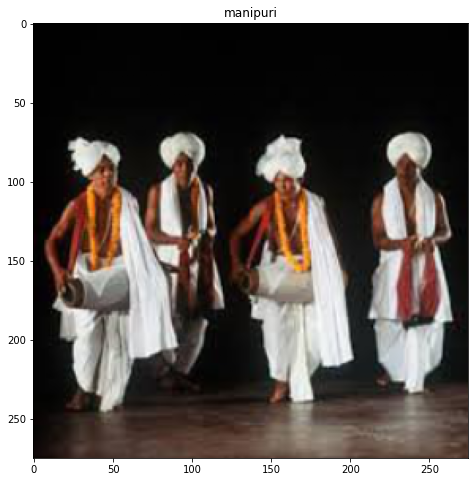

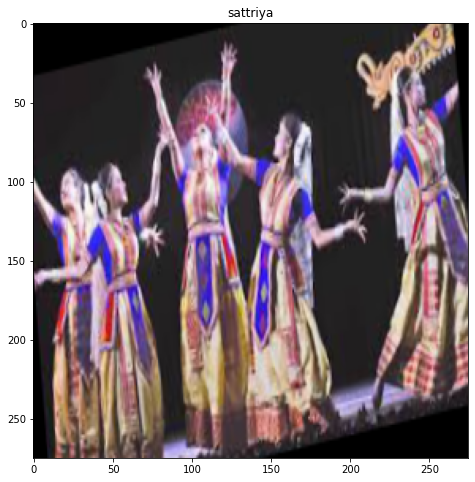

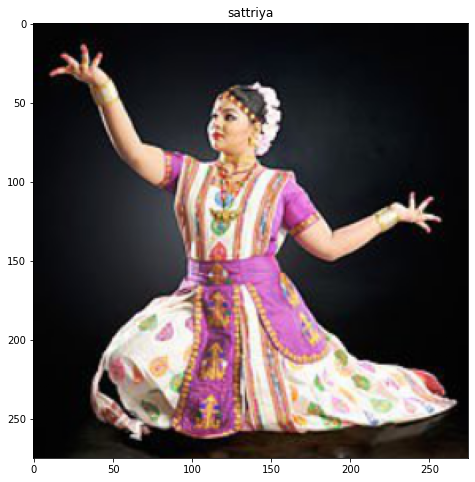

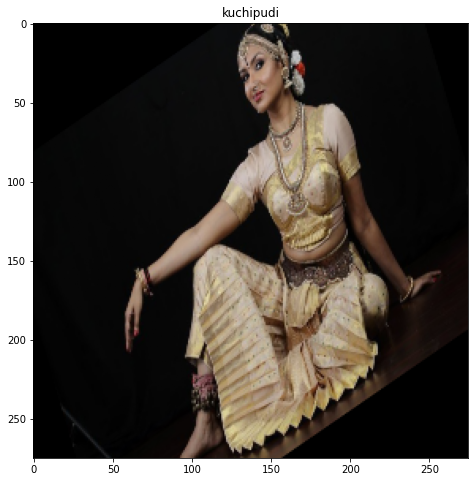

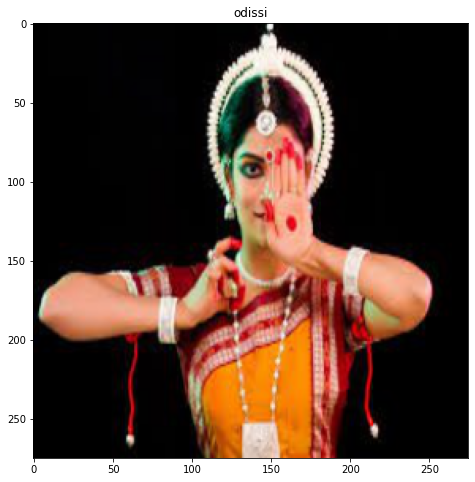

In [ ]:
for i in range(0,25,5):
    plt.figure(figsize=(12,8))
    plt.title(get_key(int(train_y[i][0])))
    plt.imshow(train_x[i])

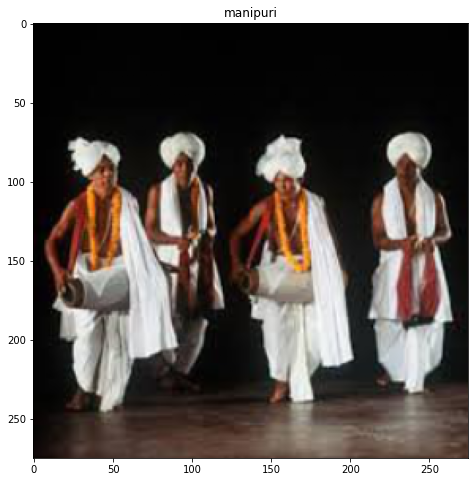

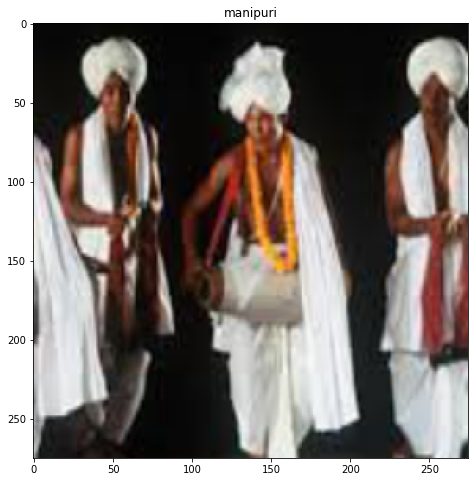

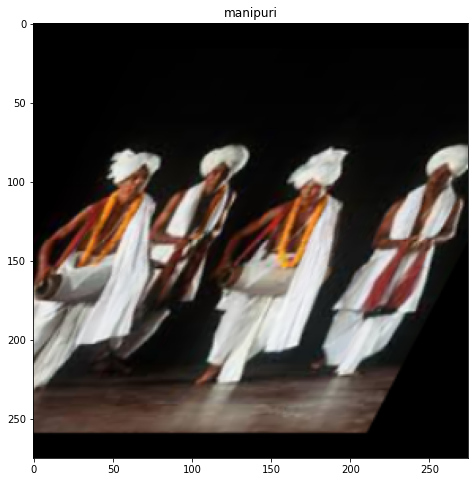

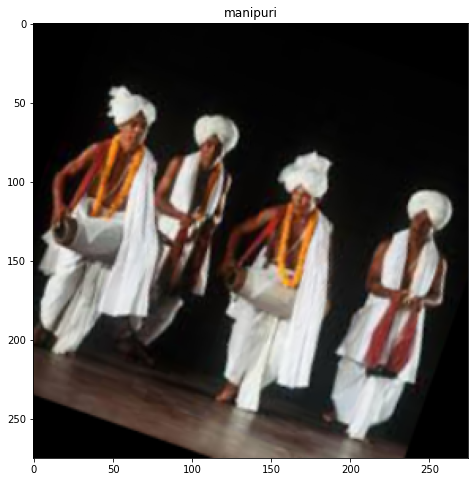

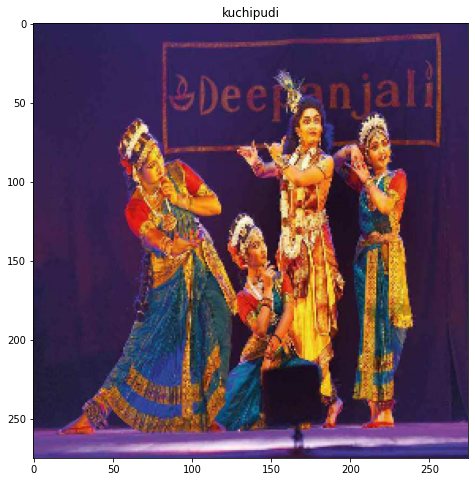

In [ ]:
for i in range(0,5):
    plt.figure(figsize=(12,8))
    plt.title(get_key(int(train_y[i][0])))
    plt.imshow(train_x[i])

### Splitting the data into training and validation sets

In [ ]:
train_size=train_x.shape[0]-int(train_x.shape[0]*0.25)
train_size

1365

In [ ]:
test_x=train_x[train_size:]
test_y=train_y[train_size:]
train_x=train_x[:train_size]
train_y=train_y[:train_size]
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(1365, 275, 275, 3) (1365, 1) (455, 275, 275, 3) (455, 1)


## Defining and training the model

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
# traing using transfer learning
vggmodel =VGG16(weights='imagenet', include_top=False, input_shape = (275, 275, 3),pooling='max')

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
vggmodel.trainable=False
model = models.Sequential([vggmodel,
                           layers.Dense(1024, activation='relu'),
                           layers.Dropout(0.15),
                           layers.Dense(512, activation='relu'),
                           layers.Dropout(0.15),
                           layers.Dense(256, activation='relu'),
                           layers.Dropout(0.15),
                           layers.Dense(8, activation='softmax')])

- Here we have used an already available CNN architecture in Keras i.e. VGG architecture(without the top layers) for better performance.
- On top of the VGG model we have added a dense network.
- The VGG model parameters have been made non-trainable otherwise the already learned weights would be altered.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
optimizer=optimizers.RMSprop(1e-2),
metrics=['acc'])

In [ ]:
earlystopper = EarlyStopping(patience=8, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=1e-7, verbose=1)

- Defining the callbacks.

In [ ]:
history = model.fit(train_x,
                    train_y,
                    epochs=100,
                    batch_size=128,
                    validation_data=(test_x,test_y),
                    callbacks=[earlystopper,reduce_lr])

Train on 1365 samples, validate on 455 samples
Epoch 1/100
1365/1365 [==============================] - 60s 44ms/step - loss: 198.5065 - acc: 0.1260 - val_loss: 2.5574 - val_acc: 0.1253
Epoch 2/100
1365/1365 [==============================] - 26s 19ms/step - loss: 2.5234 - acc: 0.1927 - val_loss: 2.7255 - val_acc: 0.1341
Epoch 3/100
1365/1365 [==============================] - 26s 19ms/step - loss: 2.1546 - acc: 0.1744 - val_loss: 2.0899 - val_acc: 0.1648
Epoch 4/100
1365/1365 [==============================] - 26s 19ms/step - loss: 2.1827 - acc: 0.1810 - val_loss: 2.0230 - val_acc: 0.2000
Epoch 5/100
1365/1365 [==============================] - 26s 19ms/step - loss: 2.1981 - acc: 0.1333 - val_loss: 2.0415 - val_acc: 0.2659
Epoch 6/100
1365/1365 [==============================] - 26s 19ms/step - loss: 2.1642 - acc: 0.1729 - val_loss: 2.0648 - val_acc: 0.1297
Epoch 7/100
1365/1365 [==============================] - 26s 19ms/step - loss: 2.0735 - acc: 0.1597 - val_loss: 2.2070 - val_acc:

In [ ]:
#tf.keras.backend.clear_session()

<Figure size 432x288 with 0 Axes>

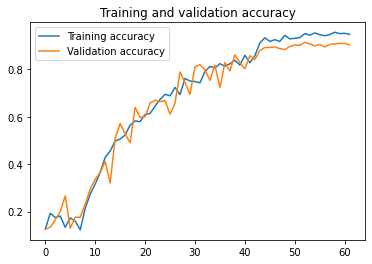

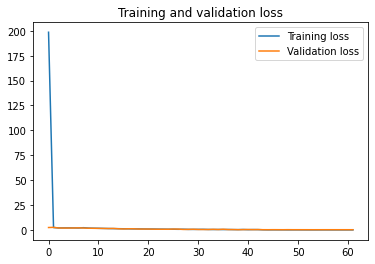

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history[ 'acc' ]
val_acc  = history.history[ 'val_acc' ]
loss     = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot( epochs, acc , label = 'Training accuracy')
plt.plot( epochs, val_acc, label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot( epochs, loss , label = 'Training loss')
plt.plot( epochs, val_loss, label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

## Making predictions for the test data

In [ ]:
test=pd.read_csv(r'/content/drive/My Drive/Hackerearth dance form classification/test.csv')
test.head()

,Image
0,508.jpg
1,246.jpg
2,473.jpg
3,485.jpg
4,128.jpg


In [ ]:
test.shape

(156, 1)

In [ ]:
test_tensor=np.empty((test.shape[0],275,275,3),dtype='float32')
for i in test.index:
    path=os.path.join(test_path,test['Image'][i])
    i  mage = imageio.imread(path)
    img_tensor = get_img_tensor(image)
    test_tensor[i] = img_tensor

In [ ]:
test_tensor.shape

(156, 275, 275, 3)

In [ ]:
predictions=model.predict_classes(test_tensor)
predictions=pd.Series(predictions)

In [ ]:
predictions=predictions.apply(lambda x:get_key(x))

In [ ]:
test['target']=predictions
test.head()

,Image,target
0,508.jpg,kuchipudi
1,246.jpg,odissi
2,473.jpg,odissi
3,485.jpg,odissi
4,128.jpg,bharatanatyam


In [ ]:
test.to_csv(r'/content/drive/My Drive/Hackerearth dance form classification/final_submission.csv',index=False)